The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model = llama3_8bchat, length_norm_type = none, task = SelfVOther

Dataset = CNN, Paradigm = Pairwise Summaries


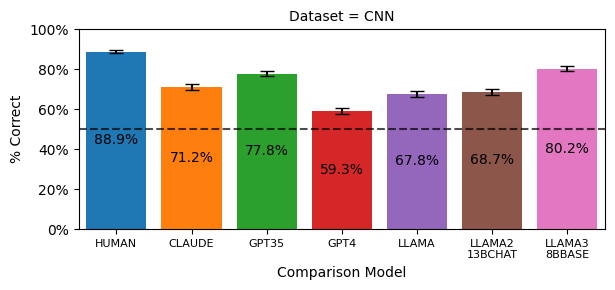


Dataset = XSUM, Paradigm = Pairwise Summaries


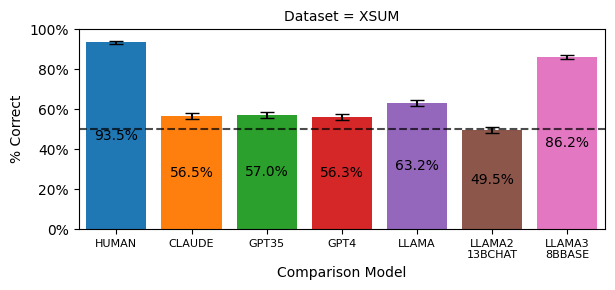


Dataset = DOLLY, Paradigm = Pairwise Summaries


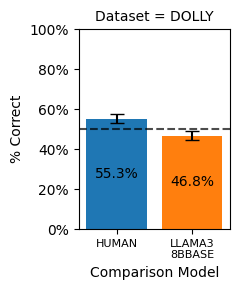


Dataset = SAD, Paradigm = Pairwise Completions


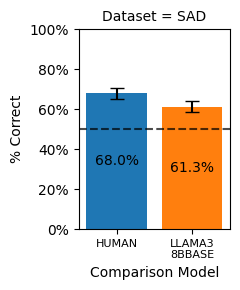

In [21]:
### Compute accuracy of model choices for pairwise task

from initialize import *
%load_ext autoreload
%autoreload 2

from tabulate import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 

def plot_table_as_bar_chart(ax, table, headers, N, task, dataset, colors=None):
    models = [row[0] for row in table]
    data = {row[0]: {h: row[i+1] for i, h in enumerate(headers[1:])} for row in table}
    
    n_models = len(models)
    n_categories = len(headers[1:])
    x = np.arange(n_models)
    
    total_width = 0.8  # Total width of all bars at one x location
    width = total_width / n_categories  # Width of each bar

    if colors is None:
        default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        if n_categories == 1:
            # Map colors to models when there's only one category
            colors = {model: default_colors[i % len(default_colors)] for i, model in enumerate(models)}
        else:
            # Map colors to categories when there are multiple categories
            colors = {category: default_colors[i % len(default_colors)] for i, category in enumerate(headers[1:])}
    
    # Add a horizontal dashed line at 50%
    ax.axhline(y=50, color='black', linestyle='--', alpha=0.7)
    
    for i, category in enumerate(headers[1:]):
        values = [float(data[model][category].replace("%", "")) / 100 for model in models]
        # Calculate 95% CI
        z=2.576#1.96
        if category == headers[-1]:
            ci = [z * np.sqrt((v * (1 - v)) / (N * 2)) for v in values]
        else:
            ci = [z * np.sqrt((v * (1 - v)) / N) for v in values]
        # Convert values to percentages
        values_percent = [v * 100 for v in values]
        ci_percent = [c * 100 for c in ci]
        offsets = (i - (n_categories - 1) / 2) * width

        if n_categories == 1:
            # Assign colors per model
            bar_colors = [colors[model] for model in models]
        else:
            # Assign the same color for all bars in this category
            bar_colors = colors[category]
        
        bars = ax.bar(
            x + offsets,
            values_percent,
            width,
            label=category,
            yerr=ci_percent,
            capsize=5,
            color=bar_colors
        )
        # Add percentage labels inside the bars
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                height / 2,
                f'{height:.1f}%',
                ha='center',
                va='center',
                fontsize=10
            )
    
    ax.set_ylabel('% Correct')
    ax.set_xlabel(headers[0])
    ax.set_title(f"Dataset = {dataset.upper()}", fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels([model.upper().replace("_","\n") for model in models], rotation=0, ha='center', fontsize=8)
    # Adjust y-axis to show percentages
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Adjust x-axis limits to accommodate the bars
    ax.set_xlim(-0.5, n_models - 0.5)


def avg(l):
    return sum(l) / len(l)
def get_acc_table(results, corvals, models=[]):
    if models == []: models = sorted(set([result['model'] for result in results if result['model']!="sonnet"]), key=lambda x: (x != 'human', x))#models = sorted(set([result['model'] for result in results]))
    task = 'detection' 
    table = [[model.replace("_filteredlen",""), 
                            avg([result[f'forward_{task}'] == corvals[0] and result[f'backward_{task}'] == corvals[1] for result in results if result['model']==model]),
                            avg([result[f'forward_{task}'] == corvals[1] and result[f'backward_{task}'] == corvals[0] for result in results if result['model']==model]),
                            avg([result[f'forward_{task}'] == result[f'backward_{task}'] for result in results if result['model']==model]),
                            avg([result[f'forward_{task}_logprob'][corvals[0]] + result[f'backward_{task}_logprob'][corvals[1]] > 
                                 result[f'forward_{task}_logprob'][corvals[1]] + result[f'backward_{task}_logprob'][corvals[0]] for result in results if result['model']==model]) if isinstance(results[0][f'forward_{task}_logprob'], dict) else 0,
                            avg([int(result[f'forward_{task}'] == corvals[0]) + int(result[f'backward_{task}'] == corvals[1]) for result in results if result['model']==model])/2,
    ] for model in models]

    #table = [row + [row[2] / (row[2] + row[3]) if any(i != 0 for i in [row[2], row[3]]) else 0] for row in table]

    table = [row[0:1] + [f"{round(i*100, 1)}%" for i in row[1:]] for row in table]
    return table
    print(tabulate(table, headers = ['Comparison Model', 'Correct', 'Incorrect', 'Ambiguous', 'LP Avg', 'Correct Full']))#['Comparison Model', 'Ambiguous', 'Correct', 'Incorrect', 'LP Avg', 'Zapped']
    ###print(tabulate(table, headers = ['Comparison Model', 'Correct', 'Incorrect', 'Ambiguous', 'Correct Full']))

#corvals = ['A','B']
#results = load_from_json(f'completions/sad_llama3_8bchat_SvO_continuation_paper_untuned.json')
#print_ambig_table(results, corvals)

task = TaskType.SelfVOther
model_name = "llama3_8bchat"
datasets = ["cnn", "xsum", "dolly", "sad"]
cmp_model_names = ["llama3_8bchat"] if task == TaskType.HumanVModel else []
alias = ""
length_norm_type = "none"#"trimmed"#"filtered" #
test = "acc_table" #"pplx_table"#"reg_table"#"len_table" #

corvals = ['2','1'] if "HumanVModel" in task.name else ['1','2']

print(f"Model = {model_name}, length_norm_type = {length_norm_type}, task = {task.name}")
for dataset in datasets:
    paradigm = "Completions" if dataset == "sad" else "Summaries"
    print(('' if test == 'reg_table' else '\n') + f"Dataset = {dataset.upper()}, Paradigm = Pairwise {paradigm}")
    if dataset == "sad":
        if length_norm_type == "none": suffix = "_longer_untrimmed"
        elif length_norm_type == "filtered": suffix = "_full"
        else: suffix = "_longer"
        ddir = "completions_longer" if "longer" in suffix else "completions_full" if "full" in suffix else "completions"
        data = load_from_json(f'{ddir}/{dataset}_{model_name}_{task.value}_Continuation{suffix}_untuned.json')
    else:
        if length_norm_type == "trimmed": suffix = "_trim" if model_name == "sonnet" else "_trimmed" 
        elif length_norm_type == "filtered": suffix = "_filteredlen"
        else: suffix = "_untrimmed" #""
        if task == TaskType.HumanVModel:
            if suffix == "_filteredlen": suffix = suffix+suffix
            if suffix == "_untrimmed": suffix = ""
            data = []
            for compmodel in cmp_model_names:
                fname = f'choice_results_humanVmodel/{dataset}_{model_name}_HvM_Mis{compmodel}{suffix}_untuned.json'
                if not os.path.exists(fname): continue
                data.extend(load_from_json(fname))
        elif task == TaskType.SelfVOther:
            try:
                data = load_from_json(f'choice_results/{dataset}_{model_name}_SvO{suffix}_untuned.json')
            except:
                if not os.path.exists(f'choice_results/{dataset}_{model_name}_pairwise_untuned.json'): continue
                data = load_from_json(f'choice_results/{dataset}_{model_name}_pairwise_untuned.json')

    if test == "acc_table":
        table = np.array(get_acc_table(data, corvals))
        ###print(tabulate(table[:,[0,-2,-1]], headers = ['Comparison Model', 'LP Avg', 'Correct Full']))
        fig_width = len(table) * 0.75 + 1  # Adjust figure width based on number of models
        fig, axs = plt.subplots(1, 1, figsize=(fig_width, 3))
        if model_name == "sonnet":
            plot_table_as_bar_chart(axs, [[row[0], row[-1]] for row in table], ['Comparison Model', 'Correct Full'], len(data), task, dataset, colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][1]])
        else:
            plot_table_as_bar_chart(axs, [[row[0], row[-1]] for row in table], ['Comparison Model', 'Correct Full'], len(data)/2, task, dataset)#, colors = ["blue", "purple"])
#            plot_table_as_bar_chart(axs, [[row[0], row[-2]] for row in table], ['Comparison Model', 'Correct Prob Avg'], len(data), task, dataset)#, colors = ["blue", "purple"])
        plt.tight_layout()
        plt.savefig(f'./figs_new/{dataset}_{length_norm_type}_{model_name}2.png', dpi=300, bbox_inches='tight')
        plt.show()
    elif test == "pplx_table":
        results = calculate_perplexity_metrics(data, corvals=corvals)
        print(format_perplexity_metrics_table(results, task=task))
    elif test == "len_table":
        if dataset == "sad": responses, _ = load_data_sad(ddir = ddir)
        else: responses, _, _ = load_data(dataset)
        results = calculate_length_metrics(data, responses, "human" if "HvM" in task.value else model_name, corvals=corvals, trim = (length_norm_type == "trimmed"))
        print(format_length_metrics_table(results, task=task))
    elif test == "reg_table":
        if dataset == "sad": responses, _ = load_data_sad(ddir = ddir)
        else: responses, _, _ = load_data(dataset)
        results = calculate_impact_full(data, responses, model_name, corvals=corvals, separate=True, trim = (length_norm_type == "trimmed"), type = "logistic")    
        sdf, df = format_results_full(results)#display(sdf)
        print(df)
    else:
        if dataset == "sad": responses, _ = load_data_sad(ddir = ddir)
        else: responses, _, _ = load_data(dataset)
        visualize_choice_data(data, responses, model_name, comp_model="human", corvals=corvals)


In [10]:
table

array([['human', '2.9%', '2.9%', '94.3%', '50.8%', '50.0%'],
       ['llama3_8bchat', '2.6%', '4.6%', '92.8%', '48.9%', '49.0%']],
      dtype='<U13')

In [39]:
### compute relationships with summary-level perplexity
#!pip install scipy
import numpy as np
from scipy import stats
from tabulate import tabulate

def calculate_perplexity_metrics(data, corvals=['1','2']):
    # Group data by model
    models = {}
    for item in data:
        model = item['model']
        if model=='sonnet': continue
        if model not in models:
            models[model] = []
        models[model].append(item)
    sorted_model_names = sorted(models.keys())
    if "human" in sorted_model_names:
        sorted_model_names.remove("human")
        sorted_model_names.insert(0, "human")

    results = {}
    for model in sorted_model_names:
        items = models[model]
        metrics = {}
        
        def avg(lst):
            return sum(lst) / len(lst)
        def med(lst):
            return np.median(lst)
        
        # 1) Average self_summary_perplexity
        metrics['avg_self_perplexity'] = med([item['self_summary_perplexity'] for item in items])
        
        # 2) Average other_summary_perplexity
        metrics['avg_other_perplexity'] = med([item['other_summary_perplexity'] for item in items])
        
        # 3) Average self-other perplexity ratio
        perplexity_ratios_raw = [item['self_summary_perplexity'] / item['other_summary_perplexity'] for item in items]
        perplexity_ratios = [.1 if l < .1 else 10 if l > 10 else l for l in perplexity_ratios_raw]
        metrics['avg_perplexity_ratio'] = med(perplexity_ratios)
        
        # 4) Average self-other logprob ratio
        logprob_ratios_raw = [
            ((item['forward_detection_logprob']['1'] + item['backward_detection_logprob']['2']) / 2) /
            ((item['forward_detection_logprob']['2'] + item['backward_detection_logprob']['1']) / 2)
            for item in items
        ]
        logprob_ratios = [.01 if lr < .01 else 100 if lr > 100 else lr for lr in logprob_ratios_raw]

        metrics['avg_logprob_ratio'] = med(logprob_ratios)
        
        # 5) Correlation between perplexity ratio and logprob ratio
        correlation, p_value = stats.pearsonr(perplexity_ratios, logprob_ratios)
        confidence_interval = stats.norm.interval(0.95, loc=correlation, scale=stats.sem(perplexity_ratios))
        metrics['perplexity_logprob_correlation'] = {
            'correlation': correlation,
            'p_value': p_value,
            'confidence_interval': confidence_interval
        }
        
        # 6, 7, 8) Average perplexity ratios for correct, incorrect, and ambiguous cases
        correct_ratios = []
        incorrect_ratios = []
        ambiguous_ratios = []
        correct_count = incorrect_count = ambiguous_count = 0
        total_count = len(items)
        correct_lower_perplexity_count = incorrect_lower_perplexity_count = total_lower_perplexity_count = 0
        
        correctness_values = []
        for item in items:
            ratio = item['self_summary_perplexity'] / item['other_summary_perplexity']
            lp = (item['forward_detection_logprob'][corvals[0]] + item['backward_detection_logprob'][corvals[1]]) / (item['forward_detection_logprob'][corvals[1]] + item['backward_detection_logprob'][corvals[0]])
            if lp>1: #item['forward_detection'] == '1' and item['backward_detection'] == '2':
                correct_ratios.append(ratio)
                correctness_values.append(1)
                correct_count += 1
                if item['self_summary_perplexity'] < item['other_summary_perplexity']:
                    correct_lower_perplexity_count += 1
                    total_lower_perplexity_count += 1
            elif lp<1:#item['forward_detection'] == '2' and item['backward_detection'] == '1':
                incorrect_ratios.append(ratio)
                correctness_values.append(-1)
                incorrect_count += 1
                if item['self_summary_perplexity'] < item['other_summary_perplexity']:
                    incorrect_lower_perplexity_count += 1
                    total_lower_perplexity_count += 1
            else:
                ambiguous_ratios.append(ratio)
                correctness_values.append(0)
                ambiguous_count += 1
                if item['self_summary_perplexity'] < item['other_summary_perplexity']:
                    total_lower_perplexity_count += 1
        
        metrics['percent_total_correct'] = correct_count / total_count * 100
        metrics['avg_perplexity_ratio_correct'] = med(correct_ratios) if correct_ratios else None
        metrics['avg_perplexity_ratio_incorrect'] = med(incorrect_ratios) if incorrect_ratios else None
        metrics['avg_perplexity_ratio_ambiguous'] = med(ambiguous_ratios) if ambiguous_ratios else None
        
        # 9) Correlation between perplexity ratio and correctness
        correctness_correlation, correctness_p_value = stats.pearsonr(perplexity_ratios, correctness_values)
        correctness_confidence_interval = stats.norm.interval(0.95, loc=correctness_correlation, scale=stats.sem(perplexity_ratios))
        metrics['perplexity_correctness_correlation'] = {
            'correlation': correctness_correlation,
            'p_value': correctness_p_value,
            'confidence_interval': correctness_confidence_interval
        }
        
        # 10, 11, 12) Percentages of lower self perplexity
        metrics['percent_correct_lower_perplexity'] = (correct_lower_perplexity_count / correct_count * 100) if correct_count else None
        metrics['percent_incorrect_lower_perplexity'] = (incorrect_lower_perplexity_count / incorrect_count * 100) if incorrect_count else None
        metrics['percent_total_lower_perplexity'] = total_lower_perplexity_count / total_count * 100
        
        results[model] = metrics
    
    return results

def format_perplexity_metrics_table(results, task=""):
    headers = [
        "Model",
        "S Plx",
        "O Plx",
        "S/O Plx",
        "S/O LogPr",
        "Plx-LogPr Corr",
        "S/O Plx (C)",
        "S/O Plx (I)",
#        "Plx-Cor Corr",
        "%C S<O Plx",
        "%I S<O Plx",
        "%Tot S<O Plx",
        "%C"
    ]
    if task == "HvM": headers = [h.replace("S","H").replace("O","M") for h in headers] ### handle HvM format

    table_data = []
    for model, metrics in results.items():
        row = [
            model,
            f"{metrics['avg_self_perplexity']:.2g}",
            f"{metrics['avg_other_perplexity']:.2g}",
            f"{metrics['avg_perplexity_ratio']:.2g}",
            f"{metrics['avg_logprob_ratio']:.2g}",
            f"{metrics['perplexity_logprob_correlation']['correlation']:.2f} "
            f"({metrics['perplexity_logprob_correlation']['confidence_interval'][0]:.2f}, "
            f"{metrics['perplexity_logprob_correlation']['confidence_interval'][1]:.2f})",
            f"{metrics['avg_perplexity_ratio_correct']:.2g}" if metrics['avg_perplexity_ratio_correct'] is not None else 'N/A',
            f"{metrics['avg_perplexity_ratio_incorrect']:.2g}" if metrics['avg_perplexity_ratio_incorrect'] is not None else 'N/A',
#            f"{metrics['perplexity_correctness_correlation']['correlation']:.2f} "
#            f"({metrics['perplexity_correctness_correlation']['confidence_interval'][0]:.2f}, "
#            f"{metrics['perplexity_correctness_correlation']['confidence_interval'][1]:.2f})",
            f"{metrics['percent_correct_lower_perplexity']:.2g}" if metrics['percent_correct_lower_perplexity'] is not None else 'N/A',
            f"{metrics['percent_incorrect_lower_perplexity']:.2g}" if metrics['percent_incorrect_lower_perplexity'] is not None else 'N/A',
            f"{metrics['percent_total_lower_perplexity']:.2g}",
            f"{metrics['percent_total_correct']:.2g}"
        ]
        table_data.append(row)

    return tabulate(table_data, headers=headers)

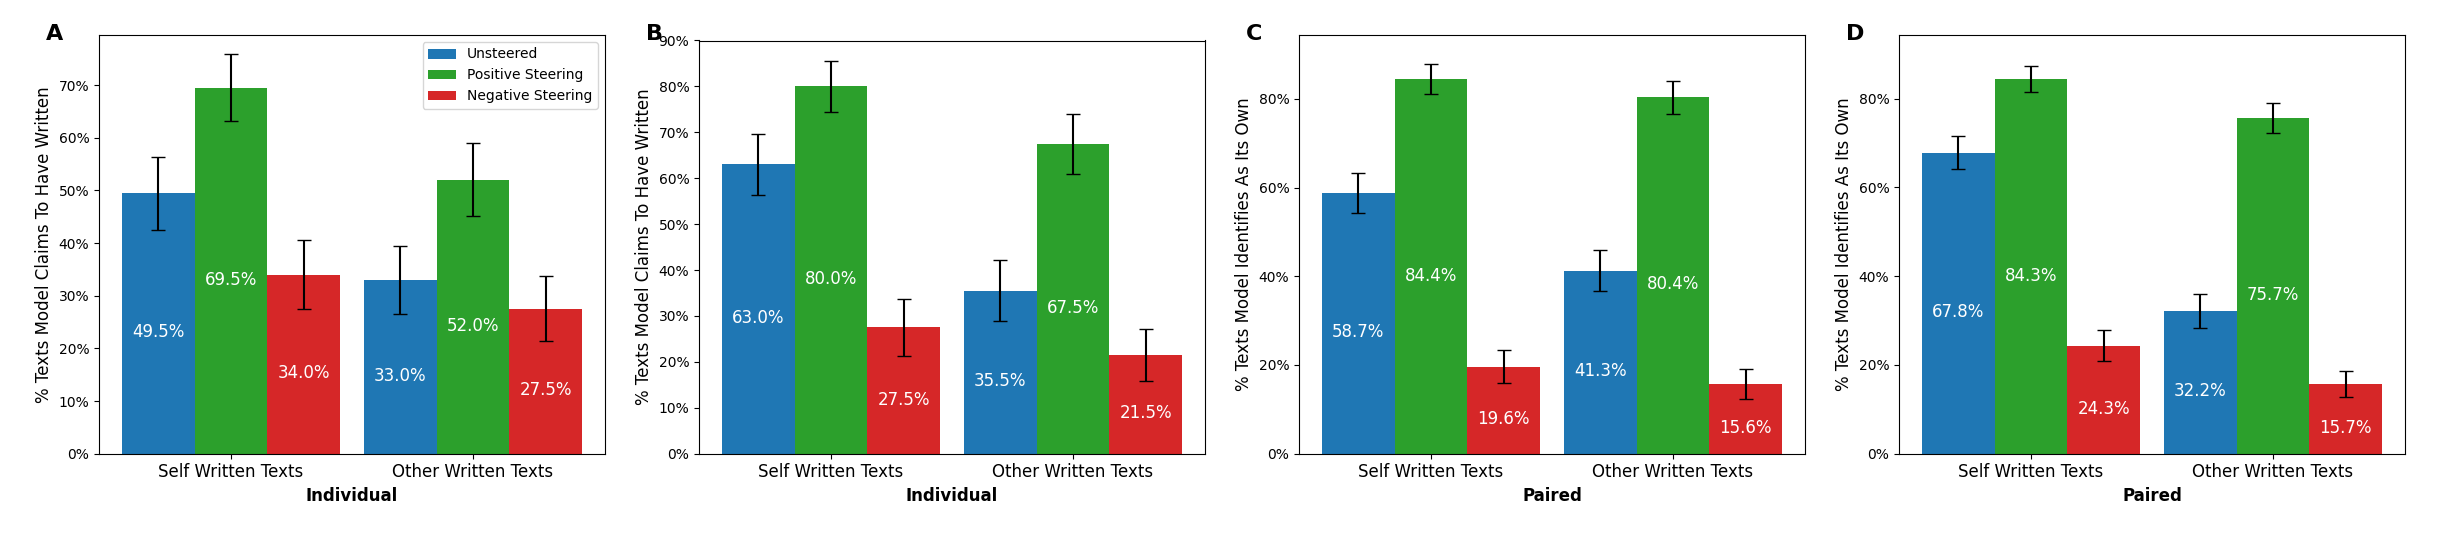

In [56]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import string


def add_labels_adjusted(image_name, num_columns, num_rows=1):
###    fig, ax = plt.subplots(figsize=(10, 5)) 
    image = Image.open(image_name+".png")
    image_array = np.array(image)
    dpi=200
    figsize = (image_array.shape[1] / dpi, image_array.shape[0] / dpi)
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.imshow(image_array, interpolation='none')  
    
    # Calculate the spacing based on the number of columns and rows
    column_width = image_array.shape[1] // num_columns
    row_height = image_array.shape[0] // num_rows

    # Define labels based on the number of subfigures
    labels = list(string.ascii_uppercase[:num_columns * num_rows])

    # Generate positions for each label based on the upper left of each subplot
    positions = [(column_width * i + 20, 4 + row_height * (i // num_columns)) for i in range(num_columns * num_rows)]
    
    # Place labels on the plot
    for label, position in zip(labels, positions):
        ax.text(position[0], position[1], label, color='black', fontsize=8, fontweight='bold', va='top', ha='left')

    ax.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(image_name+"_labeled.png", bbox_inches='tight', pad_inches=0, dpi=dpi) 

add_labels_adjusted("figs_new/coloring_combined", num_columns=4, num_rows=1)

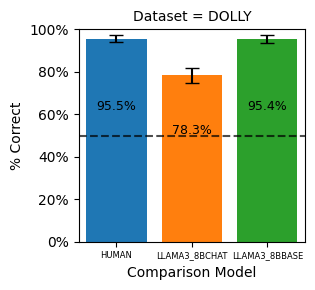

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 

def plot_table_as_bar_chart(ax, models, values, N, dataset, colors=None):
    data = {models[i]: {"Comparison Model": values[i]} for i in range(len(models))}
    
    n_models = len(models)
    n_categories = 1
    x = np.arange(n_models)
    
    total_width = 0.8  # Total width of all bars at one x location
    width = total_width / n_categories  # Width of each bar

    if colors is None:
        default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        if n_categories == 1:
            # Map colors to models when there's only one category
            colors = {model: default_colors[i % len(default_colors)] for i, model in enumerate(models)}
    
    # Add a horizontal dashed line at 50%
    ax.axhline(y=50, color='black', linestyle='--', alpha=0.7)
    
    for i, category in enumerate(["Comparison Model"]):
        values = [float(data[model][category].replace("%", "")) / 100 for model in models]
        # Calculate 95% CI
        z=2.576#1.96
        ci = [z * np.sqrt((v * (1 - v)) / N) for v in values]
        # Convert values to percentages
        values_percent = [v * 100 for v in values]
        ci_percent = [c * 100 for c in ci]
        offsets = (i - (n_categories - 1) / 2) * width

        if n_categories == 1:
            # Assign colors per model
            bar_colors = [colors[model] for model in models]
        else:
            # Assign the same color for all bars in this category
            bar_colors = colors[category]
        
        bars = ax.bar(
            x + offsets,
            values_percent,
            width,
            label=category,
            yerr=ci_percent,
            capsize=5,
            color=bar_colors
        )
        # Add percentage labels inside the bars
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                height * 2/3,
                f'{height:.1f}%',
                ha='center',
                va='center',
                fontsize=9
            )
    
    ax.set_ylabel('% Correct')
    ax.set_xlabel("Comparison Model")
    ax.set_title(f"Dataset = {dataset.upper()}", fontsize=10)
    ax.set_xticks(x)
    ax.set_xticklabels([model.upper() for model in models], rotation=0, ha='center', fontsize=6)
    # Adjust y-axis to show percentages
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Adjust x-axis limits to accommodate the bars
    ax.set_xlim(-0.5, n_models - 0.5)


# Sample size and values (assuming all three categories have the same sample size for simplicity)
N = 1000  # You should adjust this based on your actual sample sizes for each category
values = ["95.5%", "78.3%", "95.4%"]
labels = ['HUMAN', 'LLAMA3_8BCHAT', 'LLAMA3_8BBASE']

fig_width = 3 * 0.75 + 1  # Adjust figure width based on number of models
fig, axs = plt.subplots(1, 1, figsize=(fig_width, 3))
plot_table_as_bar_chart(axs, labels, values, 1000, "DOLLY")#, colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][1]])
plt.tight_layout()
plt.savefig(f'./figs_new/dolly_sonnet.png', dpi=300, bbox_inches='tight')
plt.show()
